In [1]:
import sys
sys.path.append('..')
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from cartopy import crs as ccrs
from metpy.units import units

from Map import Map
from Data import Data, ValidTime

In [8]:
'''Define Model Parameters'''
LOCATION = 'texas'
THRESHOLD = 25
MODEL_DATE = '20230610'
CYCLE = '18'
FORECAST_HOUR = '12'

# Define area to retrieve data
LEFT_LON = -110
RIGHT_LON = -80
TOP_LAT = 40
BOTTOM_LAT = 24

In [9]:
PRODUCT_MAPPING = {25: 1, 75: 2, 150: 3}.get(THRESHOLD, 75)
graphics_dir = Path('.') / '..' / '..' / 'graphics' / 'models' / 'href'

In [10]:
URL = ('https://nomads.ncep.noaa.gov/cgi-bin/filter_hrefconus.pl?'
              f'file=href.t{CYCLE}z.conus.prob.f{FORECAST_HOUR}.grib2'
              f'&all_lev=on&var_MXUPHL=on&subregion='
              f'&leftlon={360 + LEFT_LON}&rightlon={360 + RIGHT_LON}'
              f'&toplat={TOP_LAT}&bottomlat={BOTTOM_LAT}&'
              f'dir=/href.{MODEL_DATE}/ensprod')

ds = Data(URL)
data = ds.pygrib_read_dataset()

In [11]:
#%%capture
updraft_helicity = data[PRODUCT_MAPPING]

# Extract lats, lons, and data values
lats, lons = updraft_helicity.latlons()
href_values = updraft_helicity.values

# Get Valid Local Time
vt = ValidTime(updraft_helicity.validityDate, updraft_helicity.validityTime, 'America/Chicago')
VALID_TIME = vt.convert_datetime_pygrib()

In [15]:
txt = str(updraft_helicity)
threshold = txt.split('> ')[1].split(')')[0].split('.')[0]

'25'

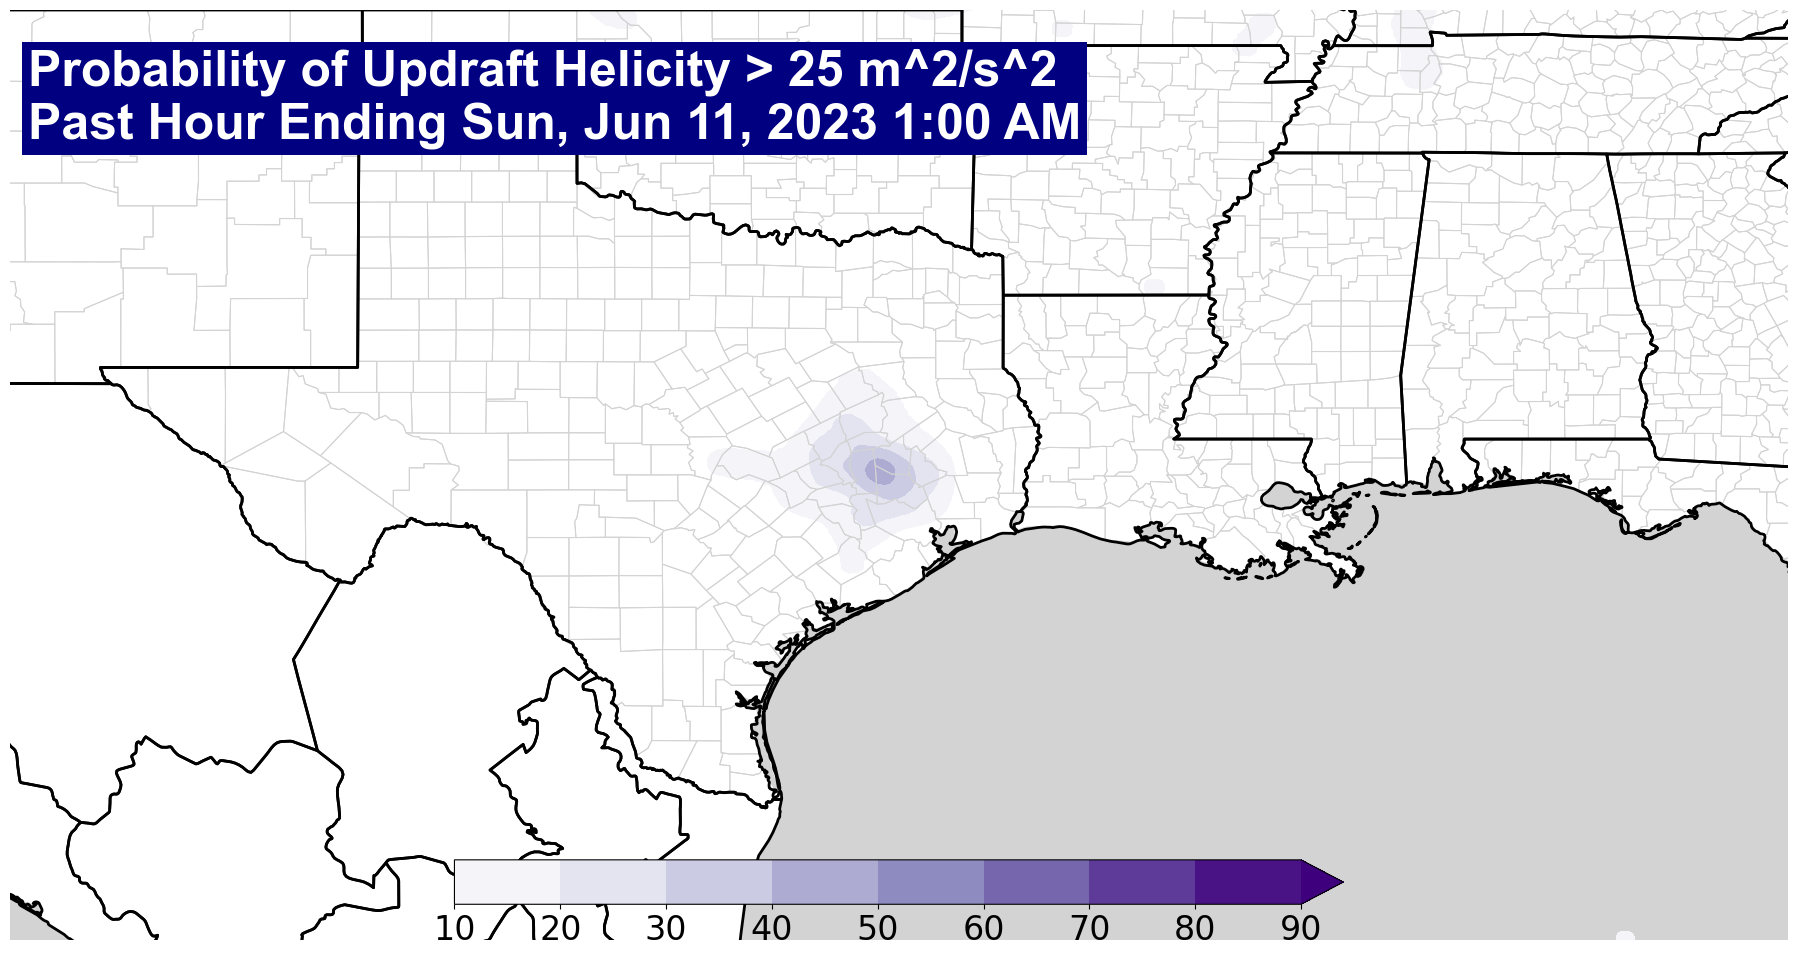

In [17]:
new_map = Map(LOCATION)
new_map.add_counties()
new_map.add_title(f'Probability of Updraft Helicity > {threshold} m^2/s^2\nPast Hour Ending {VALID_TIME}')

fig, ax = new_map.make_map()

data_range = [num for num in np.arange(10, 100, 10)]
contour = ax.contourf(lons, lats, href_values, data_range, cmap=plt.cm.Purples, 
                      extend='max', transform=ccrs.PlateCarree())

cbar = plt.colorbar(contour, orientation='horizontal', pad=-0.08, shrink=0.5,)
cbar.ax.tick_params(labelsize='24')

plt.savefig(f'{graphics_dir}/rotation-{threshold}m2s2_{FORECAST_HOUR}.png', dpi=72)
plt.show()